In [0]:
import pandas as pd
import scipy
import numpy as np
from numpy import inf
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Загрузим наш датасет

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/SergeyParamonov/HabraData/master/user_dataset.csv')
df = df[['karma', 'comments']]
df

,karma,comments
0,1.0,68
1,4.0,8
2,0.0,43
3,1.0,11
4,14.0,29
...,...,...
14670,0.0,4
14671,1.0,15
14672,0.0,32
14673,6.0,3


Мы хотим проверить, действительно ли колличесвто кармы пользователя на Хабре влияет на колличество комментариев. Для этого применим однофакторный дисперсионный анализ (ANOVA). Зависимая переменная - колличество комментариев, факторная переменная - колличество кармы пользователя. 

Гистограмма колличества коментариев выглядит так:

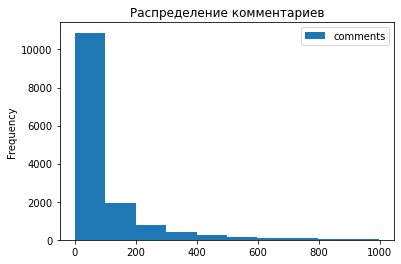

In [0]:
df.plot(kind='hist', y='comments', title='Распределение комментариев')

Мы видим, что распределение далеко от нормального. Но мы можем это исправить применив лог-трансформацию

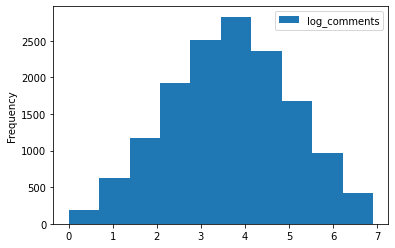

In [0]:
df['log_comments'] = np.log1p(df['comments'])
df.plot(kind='hist', y='log_comments')

Посмотрим теперь на факторную переменную:

In [0]:
df.karma.describe()

count    14675.000000
mean        17.916716
std         42.603033
min          0.000000
25%          0.000000
50%          5.000000
75%         18.000000
max       1230.000000
Name: karma, dtype: float64

Будем рассматривать karma как номенативную переменную. Для этого разобьем значения на группы:

In [0]:
min_ = int(df.karma.min())
max_ = int(df.karma.max())

breaks = [ -inf, 0, 5, 15, 25, 50, 100, inf ]
df['karma_cut'] = pd.cut(df.karma, bins=breaks, right=True)
df

,karma,comments,log_comments,karma_cut
0,1.0,68,4.234107,"(0.0, 5.0]"
1,4.0,8,2.197225,"(0.0, 5.0]"
2,0.0,43,3.784190,"(-inf, 0.0]"
3,1.0,11,2.484907,"(0.0, 5.0]"
4,14.0,29,3.401197,"(5.0, 15.0]"
...,...,...,...,...
14670,0.0,4,1.609438,"(-inf, 0.0]"
14671,1.0,15,2.772589,"(0.0, 5.0]"
14672,0.0,32,3.496508,"(-inf, 0.0]"
14673,6.0,3,1.386294,"(5.0, 15.0]"


Вот как распределяются медианы в зависимости от интервала, в который попадает карма пользователя

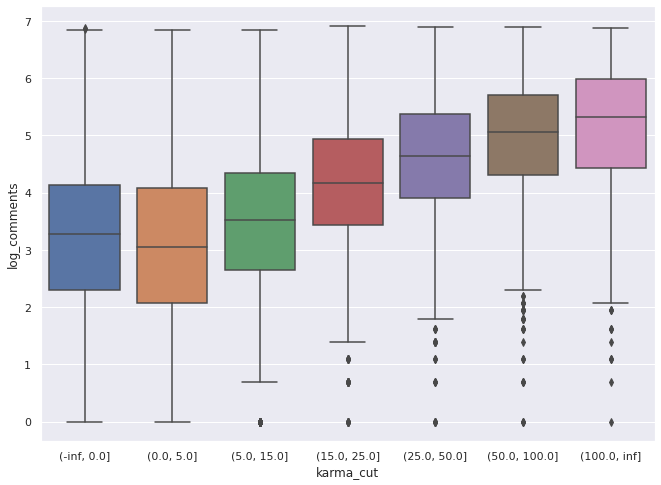

In [0]:
sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(x=df.karma_cut, y=df.log_comments)

Очевидно, что с ростом кармы растет и медиана колличества комментариев. Нашу нулевую гипотезу для дисперсионного анализа можно сформулировать так: карма не оказывает никакого влияния на логарифм количества оставляемых пользователем комментариев, а наблюдаемые различия между групповыми средними несущественны и случайны:
$$H_{0}: \mu_{0} = \mu_{1} = ... = \mu_{7}$$
Альтернативная гипотеза, соответственно, утверждает, что различия все же не случайны.

Чтобы принять или отклонить нулевую гипотезу сравним Межгрупповой средний квадрат $MS_{bg}$ и внутригрупповой средний квадрат $MS_{wg}$
$$
MS_{bg} = \frac{\sum_{i}n_{i}(\overline{X_{i}} - \overline{X})^2}{K-1}
$$ 
$$
MS_{wg} = \frac{\sum_{ij}(X_{ij} - \overline{X_{i}})^2}{N-K}
$$
где K - колличество групп, N - общий обьем выборки.
Затем воспользуемся F-критерием со степенями свободы K-1 и N-K, чтобы оценить p-уровень значимости
$$
F = \frac{MS_{bg}}{MS_{wg}}
$$

In [0]:
samples = np.array(df.groupby('karma_cut')['log_comments'])
points = samples[:,0]
samples = samples[:,1]
scipy.stats.f_oneway(samples[0], samples[1], samples[2], samples[3], samples[4], samples[5], samples[6])


F_onewayResult(statistic=556.1955527857629, pvalue=0.0)

Как мы видим полученый p-уровень гораздо меньше 0.01 => нулевая гипотеза не верна.



Обычно после ANOVA выполняют Post hoc анализ. Воспользуемся t-тестом с поправкой Бонферонни. (Еще есть критерий Тьюки, но не в этот раз)

In [0]:
p_crit = 0.05 / 20 
result = pd.DataFrame(columns=['t-value', 'p-value', 'sample-1', 'sample-2'])
for i in range(6):
    for j in range(i + 1, 7):
        t, p = scipy.stats.ttest_ind(samples[i], samples[j])
        t = round(t, 4)
        p = round(p, 4)
        result.loc[len(result)] = [t, p, points[i], points[j]]
result['similarity'] = result['p-value'] >= p_crit
result

,t-value,p-value,sample-1,sample-2,similarity
0,2.3756,0.0175,"(-inf, 0.0]","(0.0, 5.0]",True
1,-9.9565,0.0000,"(-inf, 0.0]","(5.0, 15.0]",False
2,-24.1968,0.0000,"(-inf, 0.0]","(15.0, 25.0]",False
3,-35.8051,0.0000,"(-inf, 0.0]","(25.0, 50.0]",False
4,-35.0969,0.0000,"(-inf, 0.0]","(50.0, 100.0]",False
5,-30.0675,0.0000,"(-inf, 0.0]","(100.0, inf]",False
6,-9.8816,0.0000,"(0.0, 5.0]","(5.0, 15.0]",False
7,-22.2082,0.0000,"(0.0, 5.0]","(15.0, 25.0]",False
8,-32.2373,0.0000,"(0.0, 5.0]","(25.0, 50.0]",False
9,-32.1653,0.0000,"(0.0, 5.0]","(50.0, 100.0]",False


Можно сделать вывод, что пользователи с кармой (-∞, 0] и (0, 5] оставляют примерно одинаковое log-количество комментариев, как и пользователи с кармой (50,100] и (100, ∞]. Остальные группы существенно отличаются.

## Непараметрические методы

На самом деле наши данные не проходят по условиям ANOVA. При детальном рассмотрении распределение далеко от нормального:

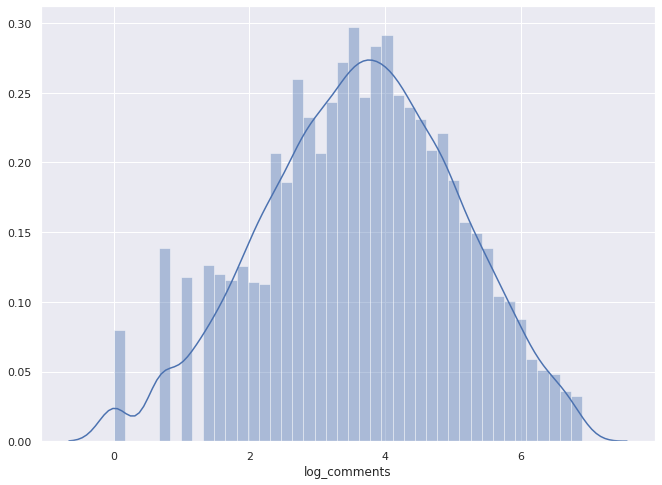

In [0]:
sns.distplot(df.log_comments)

О неоднородности распределения говорит нам тест Шапиро-Уилка:

In [0]:
print('p-уровень значимости для теста Шапиро-Уилка: ', scipy.stats.shapiro(df.log_comments)[1])

p-уровень значимости для теста Шапиро-Уилка:  5.749111781028529e-25


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Так же тест Бартлетта говорит нам о том, что дисперсия в группах не однородная

In [0]:
print('p-уровень значимости для теста Бартлетта на однородность дисперсии: ', scipy.stats.bartlett(samples[0], samples[1], samples[2], samples[3], samples[4], samples[5], samples[6])[1])

p-уровень значимости для теста Бартлетта на однородность дисперсии:  3.612884019623086e-16


Это не очень хорошо, по этому подкрепим наши результаты непараметрическим тестом Краскела-Уоллиса. В этом тесте нулевой гипотезой выступает равенство медиан во всех группах

In [0]:
print('p-уровень значимости для теста Краскела-Уоллиса: ', scipy.stats.kruskal(samples[0], samples[1], samples[2], samples[3], samples[4], samples[5], samples[6])[1])

p-уровень значимости для теста Краскела-Уоллиса:  0.0


Этот тест также позволяет отклонить нулевую гипотезу. 

Воспользуемся непараметрическими множественными сравнениями, чтобы понять какие группы близки, а какие нет. Воспользуемся критерием Манна-Уитни с корректировкой p-уровня значимости 

In [0]:
p_crit = 0.05 / 20 
result = pd.DataFrame(columns=['t-value', 'p-value', 'sample-1', 'sample-2'])
for i in range(6):
    for j in range(i + 1, 7):
        t, p = scipy.stats.mannwhitneyu(samples[i], samples[j], use_continuity=True )
        t = round(t, 7)
        p = round(p, 7)
        result.loc[len(result)] = [t, p, points[i], points[j]]
result['similarity'] = result['p-value'] >= p_crit
result

,t-value,p-value,sample-1,sample-2,similarity
0,5348765.0,0.000177,"(-inf, 0.0]","(0.0, 5.0]",False
1,7116640.0,0.000000,"(-inf, 0.0]","(5.0, 15.0]",False
2,2313001.0,0.000000,"(-inf, 0.0]","(15.0, 25.0]",False
3,1634262.0,0.000000,"(-inf, 0.0]","(25.0, 50.0]",False
4,779901.5,0.000000,"(-inf, 0.0]","(50.0, 100.0]",False
5,398528.5,0.000000,"(-inf, 0.0]","(100.0, inf]",False
6,2514217.5,0.000000,"(0.0, 5.0]","(5.0, 15.0]",False
7,826717.5,0.000000,"(0.0, 5.0]","(15.0, 25.0]",False
8,602461.5,0.000000,"(0.0, 5.0]","(25.0, 50.0]",False
9,297720.0,0.000000,"(0.0, 5.0]","(50.0, 100.0]",False


Как видно, Тест Манна-Витни говорит нам о том, что разные группы оставляют разное колличество комментариев (в отличии от t-критерия). Но все же пользователи с кармой (-∞, 0] и (0, 5], и (50,100] и (100, ∞] больше похожи друг на друга, чем все остальные

# A/B тестирование 

In [0]:
from scipy.stats import norm, chi2_contingency
import statsmodels.api as sm
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Данные о смертности после аварии
# cреди тех, кто пристегнул ремень
# и среди тех, кто не пристегнул ремень
#               survived    died
# no seat belt      1781     135
# seat belt         1443      47

In [0]:
s1 = 135            # число успехов     выборка А
n1 = 1781 + 135     # число испытаний   выборка А
s2 = 47             # число успехов     выборка А
n2 = 1443 + 47      # число испытаний   выборка А
p1 = s1/n1                  # вероятность успеха выборка А
p2 = s2/n2                  # вероятность успеха выборка Б
p = (s1 + s2)/(n1 + n2)     # вероятность успеха выборка А + Б
z = (p2 - p1) / ((p * (1 - p) * ((1/n1)+(1/n2)))**0.5)       # z- критерий

p_value = norm.cdf(z)                                        # p-value

Расчет ручками

In [0]:
print("z-критерий: {}, p-value: {}".format(z, p_value * 2))

z-метка: -5.009616324309194, p-value: 5.453865409256317e-07


Расчет через scipy.stats

In [0]:
z1, p_value1 = sm.stats.proportions_ztest([s1, s2], [n1, n2])

print("z-критерий: {}, p-value: {}".format(z1, p_value1))

z-метка: 5.009616324309194, p-value: 5.453865409256317e-07


Через Хи-квадрат Пирсона

In [0]:
arr = np.array([[s1, n1-s1], [s2, n2-s2]])
chi2, p_value2, dof, exp = chi2_contingency(arr, correction=False)

print("Хи-квадрат: {}, p-value: {}".format(chi2, p_value2))

Хи-квадрат: 25.09625571678515, p-value: 5.453865409256355e-07
